In [1]:
import numpy as np
import lbg_forecast.dust_priors as dpr
import lbg_forecast.sfh as sfh
import lbg_forecast.population_model as pop
import matplotlib.pyplot as plt

import lbg_forecast.priors_gp_dust as gppr

In [2]:
#np.save("dust_data/popcosmos_recentsfrs.npy", dust_prior.recent_sfrs)
#nagaraj22 = np.array([dust_prior.n, dust_prior.tau, dust_prior.tau1, dust_prior.ne, dust_prior.taue, dust_prior.tau1e, dust_prior.sfr])
#np.save("dust_data/saved_nagaraj22samples.npy", nagaraj22)

Loading Models
Loading Complete


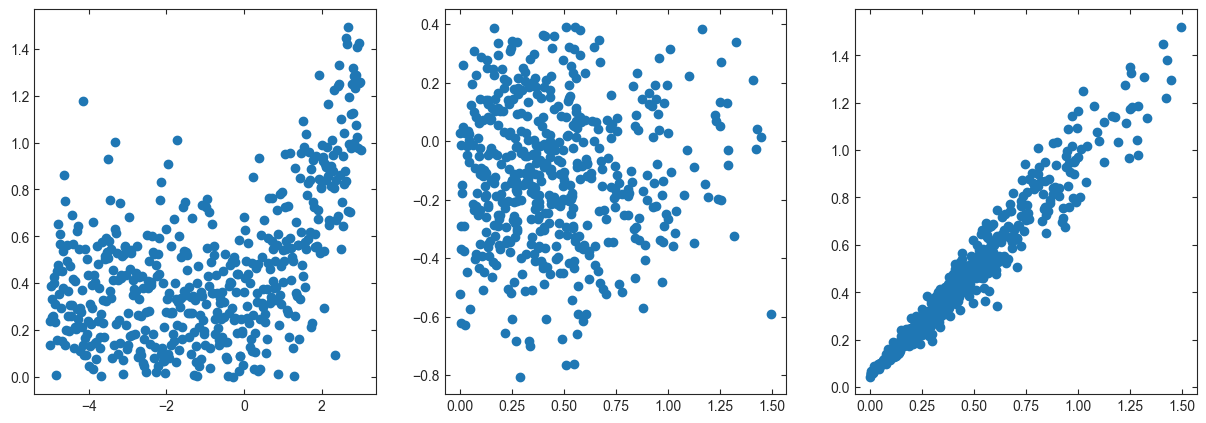

In [17]:
dust_prior = gppr.DustPrior()

f, ax = plt.subplots(1, 3, figsize=(15, 5))

ax1 = ax[0]
ax2 = ax[1]
ax3 = ax[2]

test_sfr = np.linspace(-5, 3, 500)
dust2 = dust_prior.sample_dust2(test_sfr)
dust_index = dust_prior.sample_dust_index(dust2)
dust1 = dust_prior.sample_dust1(dust2)

ax1.scatter(test_sfr, dust2)
ax2.scatter(dust2, dust_index)
ax3.scatter(dust2, dust1)

from duste.DustAttnCalc import DustAttnCalc
ngal = 2000

logM = np.random.uniform(8.74,11.30,ngal)
sfr = np.random.uniform(-5,2.5,ngal)
logZ = np.random.uniform(-1.70,0.18,ngal)
z=np.random.uniform(0.51,2.83,ngal)
i=np.random.uniform(0.09,0.97,ngal)
dobj = DustAttnCalc(sfr=sfr, logM=logM, logZ=logZ, z=z, i=i, bv=True, eff=False)
dac, dac1, n, tau, tau1, ne, taue, tau1e = dobj.calcDust(max_num_plot=0)

plt.scatter(sfr, tau)